In [2]:
import pandas as pd
import numpy as np
import joblib
import json
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN,KMeans,OPTICS
from sklearn.metrics import silhouette_score,davies_bouldin_score,make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LassoCV
from umap import UMAP
from sklearn.mixture import GaussianMixture

In [3]:
data = pd.read_csv("Data/datavalidation.csv")
data

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253006,0,1,1,1,45,0,0,0,0,1,...,1,0,3,0,5,0,1,5,6,7
253007,2,1,1,1,18,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253008,0,0,0,1,28,0,0,0,1,1,...,1,0,1,0,0,0,0,2,5,2
253009,0,1,0,1,23,0,0,0,0,1,...,1,0,3,0,0,0,1,7,5,1


In [4]:
new_data = data.drop(columns=["Diabetes_012"])

### PCA

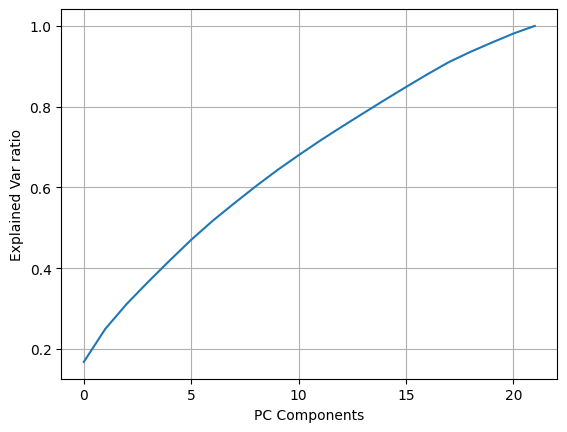

In [5]:
std = StandardScaler()
std_fit = std.fit_transform(data)
new = pd.DataFrame(std_fit,columns=data.columns)
pca = PCA()
pca_fit = pca.fit_transform(new)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("PC Components")
plt.ylabel("Explained Var ratio")
plt.grid()
plt.show()

### Feature Selection

In [6]:
ls = LassoCV(cv=5,random_state=24)
ls_fit = ls.fit(new_data,data["Diabetes_012"])
ls_fit

LassoCV(cv=5, random_state=24)

In [7]:
df = pd.DataFrame(ls_fit.coef_,index=new_data.columns)
for i,j in zip(df.index,df[0]):
    if j==0 or j<1e-3:
        print(i,j) #unwanted features

Smoker -0.006477282532264582
PhysActivity -0.006100306417598539
Fruits -0.0
Veggies -0.0018399512423850244
HvyAlcoholConsump -0.08125670974723631
NoDocbcCost -0.0
MentHlth -0.0010589307962206667
PhysHlth 0.00025483856591837305
Education -0.00624457126386181
Income -0.01389992540213758


In [8]:
new_data.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [9]:
reduced_data = new_data.drop(columns=["Smoker","PhysActivity","Fruits","Veggies","HvyAlcoholConsump","NoDocbcCost","MentHlth","PhysHlth","Education","Income"])
reduced_data                         

,HighBP,HighChol,CholCheck,BMI,Stroke,HeartDiseaseorAttack,AnyHealthcare,GenHlth,DiffWalk,Sex,Age
0,1,1,1,40,0,0,1,5,1,0,9
1,0,0,0,25,0,0,0,3,0,0,7
2,1,1,1,28,0,0,1,5,1,0,9
3,1,0,1,27,0,0,1,2,0,0,11
4,1,1,1,24,0,0,1,2,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...
253006,1,1,1,45,0,0,1,3,0,1,5
253007,1,1,1,18,0,0,1,4,1,0,11
253008,0,0,1,28,0,0,1,1,0,0,2
253009,1,0,1,23,0,0,1,3,0,1,7


In [42]:
std_mdl = StandardScaler()
std_fit = std_mdl.fit_transform(reduced_data.iloc[:,[3,7,10]])
reduced_data.iloc[:,[3,7,10]] = std_fit
reduced_data

,HighBP,HighChol,CholCheck,BMI,Stroke,HeartDiseaseorAttack,AnyHealthcare,GenHlth,DiffWalk,Sex,Age,cluster
0,1,1,1,1.934306,0,0,1,2.330404,1,0,0.315844,0
1,0,0,0,-0.534839,0,0,0,0.457921,0,0,-0.339076,1
2,1,1,1,-0.041010,0,0,1,2.330404,1,0,0.315844,3
3,1,0,1,-0.205620,0,0,1,-0.478321,0,0,0.970765,2
4,1,1,1,-0.699449,0,0,1,-0.478321,0,0,0.970765,2
...,...,...,...,...,...,...,...,...,...,...,...,...
253006,1,1,1,2.757355,0,0,1,0.457921,0,1,-0.993997,0
253007,1,1,1,-1.687107,0,0,1,1.394162,1,0,0.970765,3
253008,0,0,1,-0.041010,0,0,1,-1.414562,0,0,-1.976378,1
253009,1,0,1,-0.864059,0,0,1,0.457921,0,1,-0.339076,3


In [11]:
joblib.dump(std_mdl,"standardscaler.pkl")

['standardscaler.pkl']

### GMM(Gaussian Mixture)

In [32]:
ai = []
bi = []
for i in range(2,8):
    gs = GaussianMixture(n_components=i)
    gs_fit = gs.fit(reduced_data)
    prediction = gs_fit.predict(reduced_data)
    aic = gs_fit.aic(reduced_data) #akaike info criterion
    bic = gs_fit.bic(reduced_data) # bayesian info criterion
    ai.append(aic)
    bi.append(bic)

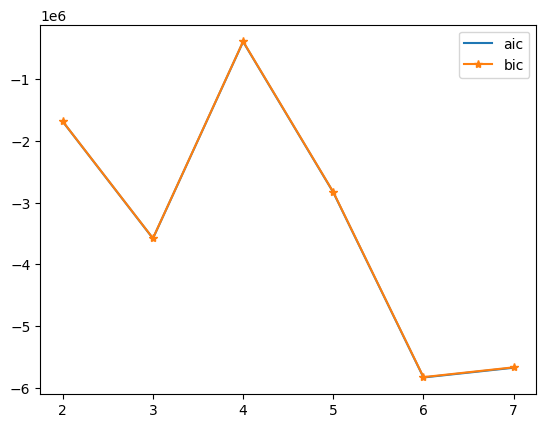

In [33]:
plt.plot(range(2,8),ai,label="aic")
plt.plot(range(2,8),bi,label="bic",marker="*")
plt.legend()

In [34]:
gs = GaussianMixture(n_components=3)
gs_fit = gs.fit(reduced_data)
gs_fit

GaussianMixture(n_components=3)

In [35]:
prediction = gs.predict(reduced_data)
prediction

array([2, 0, 1, ..., 0, 0, 1], dtype=int64)

In [36]:
silhouette_score(reduced_data,prediction,sample_size=10000)

0.1185493615599903

In [37]:
davies_bouldin_score(reduced_data,prediction)

1.748269223857239

### KMeans

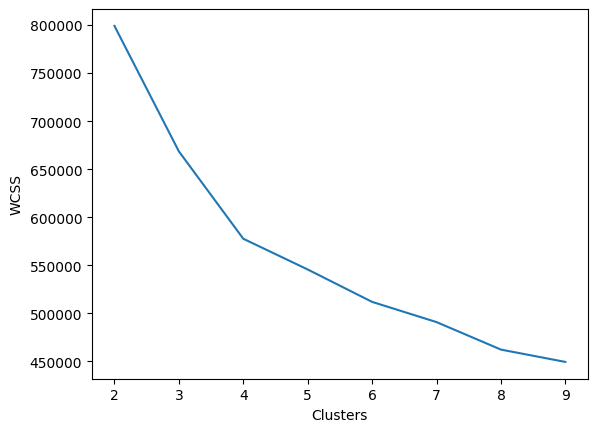

In [18]:
wcss = []
for i in range(2,10):
    m = KMeans(n_clusters=i)
    m_fit = m.fit(reduced_data)
    wcss.append(m_fit.inertia_)
plt.plot(range(2,10),wcss)
plt.xlabel("Clusters")
plt.ylabel("WCSS")
plt.show()

In [72]:
m = KMeans(n_clusters=2)
m_fit = m.fit(reduced_data)

In [73]:
labels = m_fit.labels_

In [74]:
davies_bouldin_score(reduced_data,labels)

1.81749544736927

In [76]:
silhouette_score(reduced_data,labels,sample_size=10000)

0.2003150256847418

In [57]:
reduced_data["cluster"] = labels
reduced_data

,HighBP,HighChol,CholCheck,BMI,Stroke,HeartDiseaseorAttack,AnyHealthcare,GenHlth,DiffWalk,Sex,Age,cluster
0,1,1,1,1.934306,0,0,1,2.330404,1,0,0.315844,1
1,0,0,0,-0.534839,0,0,0,0.457921,0,0,-0.339076,1
2,1,1,1,-0.041010,0,0,1,2.330404,1,0,0.315844,0
3,1,0,1,-0.205620,0,0,1,-0.478321,0,0,0.970765,0
4,1,1,1,-0.699449,0,0,1,-0.478321,0,0,0.970765,0
...,...,...,...,...,...,...,...,...,...,...,...,...
253006,1,1,1,2.757355,0,0,1,0.457921,0,1,-0.993997,1
253007,1,1,1,-1.687107,0,0,1,1.394162,1,0,0.970765,0
253008,0,0,1,-0.041010,0,0,1,-1.414562,0,0,-1.976378,1
253009,1,0,1,-0.864059,0,0,1,0.457921,0,1,-0.339076,0


In [92]:
sc = joblib.load("standardscaler.pkl")

In [93]:
org = sc.inverse_transform(reduced_data.iloc[:,[3,7,10]])

In [95]:
reduced_data.iloc[:,[3,7,10]] = org

In [96]:
reduced_data.groupby(["cluster"]).mean()

,HighBP,HighChol,CholCheck,BMI,Stroke,HeartDiseaseorAttack,AnyHealthcare,GenHlth,DiffWalk,Sex,Age
cluster,,,,,,,,,,,
0,0.511017,0.515367,0.972303,26.447739,0.053980,0.126011,0.967188,2.542152,0.187579,0.441291,9.802125
1,0.311088,0.293173,0.948789,30.837517,0.021334,0.048552,0.928043,2.465982,0.139743,0.438792,5.497014


In [59]:
joblib.dump(m,"Kmeans1.pkl")

['Kmeans1.pkl']